In [48]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data.ee import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
from src.constants import DATA_PATH, USER_PATH
import ee
import scipy.stats as stats
import numpy as np
from src.data import gedi_raster_matching
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from fastai.tabular.all import save_pickle, load_pickle
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot
from src.data import fire_perimeters
sns.set_theme()

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
importlib.reload(fire_perimeters)
from src.data.gedi_pipeline import get_severity
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB

2023-06-29 11:25:53,158 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-29 11:25:53,164 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [19]:
def get_matches(df, distance):
    return df[df.closest_distance < distance]

In [2]:
sierras_complex = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras_complex)
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")

In [3]:
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020', '2021']).filter_within_geometry(sierras)

In [4]:
sierra_firep.filter_for_fires_over_1000_acres()

In [5]:
sierra_firep.perimeters = sierra_firep.perimeters[sierra_firep.perimeters.FIRE_NAME!="DIXIE"]

In [49]:
save_pickle(f"{DATA_PATH}/jun_29_perimeters_2020_2021.pkl", sierra_firep.perimeters)

In [6]:
sierra_firep.perimeters.shape[0]

44

In [7]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_4(2)

In [8]:
# Match with corresponding NDVI for analysis
for year in range(2019, 2023):
    raster = gedi_raster_matching.get_landsat_raster_sampler(int(year))
    gedi_burned = gedi_raster_matching.sample_raster(raster, gedi_burned, kernel=1)
    gedi_burned = gedi_burned.rename(columns={"NDVI" : f"ndvi_{year}"})

In [12]:
for year in range(2019, 2023):
    gedi_burned.loc[gedi_burned['gedi_year'] == year, 'NDVI_mean'] = gedi_burned[gedi_burned['gedi_year'] == year][f"ndvi_{year}"]

In [50]:
save_pickle(f"{DATA_PATH}/gedi_burned_ndvi_vs_agbd_jun_29.pkl", gedi_burned)

In [10]:
fires_2020 = sierra_firep.perimeters[sierra_firep.perimeters.YEAR_ == "2020"]
fires_2021 = sierra_firep.perimeters[sierra_firep.perimeters.YEAR_ == "2021"]

In [13]:
gedi_2020 = gedi_burned[gedi_burned.gedi_year != 2020]
gedi_2021 = gedi_burned[gedi_burned.gedi_year != 2021]

### Analyze 2020 fires

In [14]:
burn_agbd_matches = gedi_matching.match_across_fire_perimeters(fires_2020, gedi_2020, 'agbd')

Skipped fire SALT. No matching GEDI shots found.
Skipped fire GRADE. No matching GEDI shots found.
Skipped fire FORK. No matching GEDI shots found.
Skipped fire BLUEJAY. No matching GEDI shots found.
Skipped fire WOLF. No matching GEDI shots found.
Skipped fire SLINK. No matching GEDI shots found.


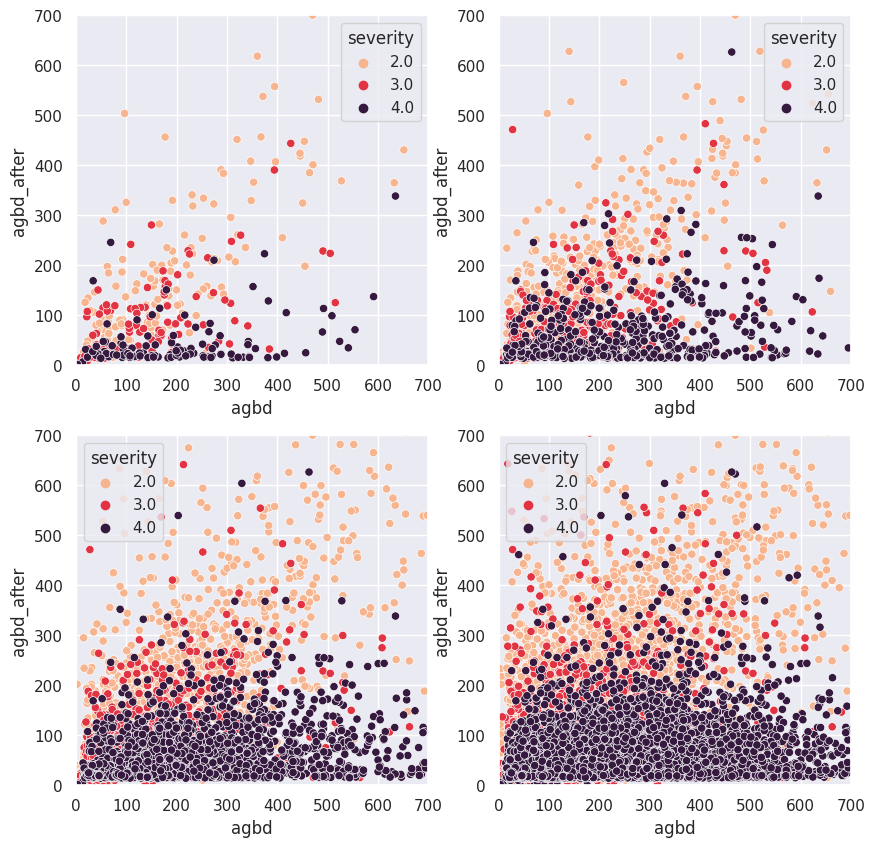

In [16]:
matching_analysis.plot_severity_for_distance(burn_agbd_matches, 'agbd')

In [15]:
burn_ndvi_matches = gedi_matching.match_across_fire_perimeters(fires_2020, gedi_2020, 'NDVI_mean')

Skipped fire SALT. No matching GEDI shots found.
Skipped fire GRADE. No matching GEDI shots found.
Skipped fire FORK. No matching GEDI shots found.
Skipped fire BLUEJAY. No matching GEDI shots found.
Skipped fire WOLF. No matching GEDI shots found.
Skipped fire SLINK. No matching GEDI shots found.


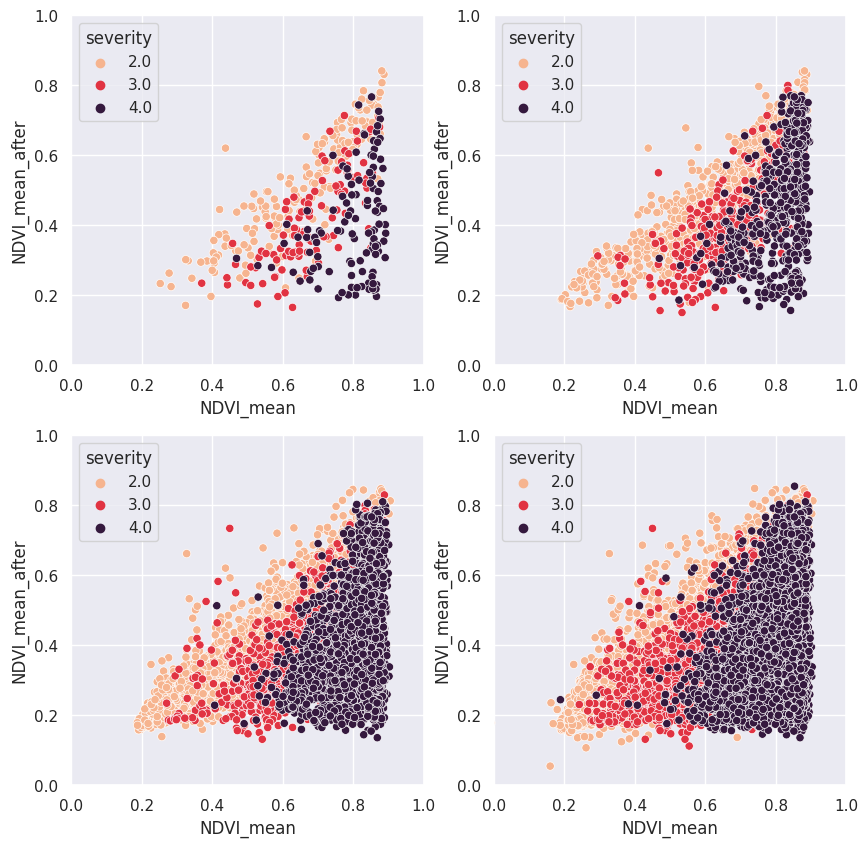

In [18]:
matching_analysis.plot_severity_for_distance(burn_ndvi_matches, 'NDVI_mean', 1)

<Axes: xlabel='agbd', ylabel='Density'>

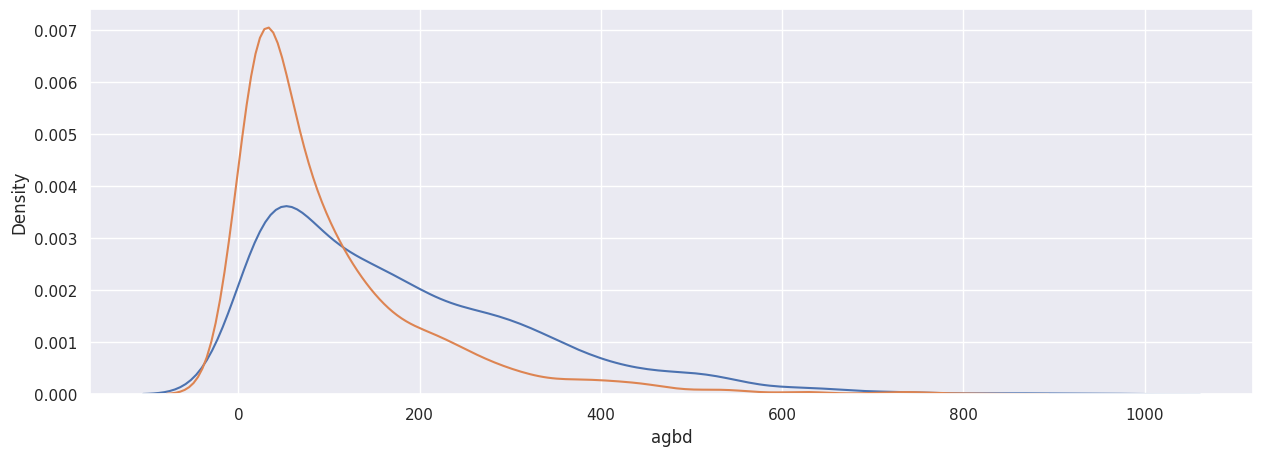

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(get_matches(burn_agbd_matches, 10), x="agbd", ax=ax)
sns.kdeplot(get_matches(burn_agbd_matches, 10), x="agbd_after", ax=ax)

<Axes: xlabel='agbd_diff', ylabel='Density'>

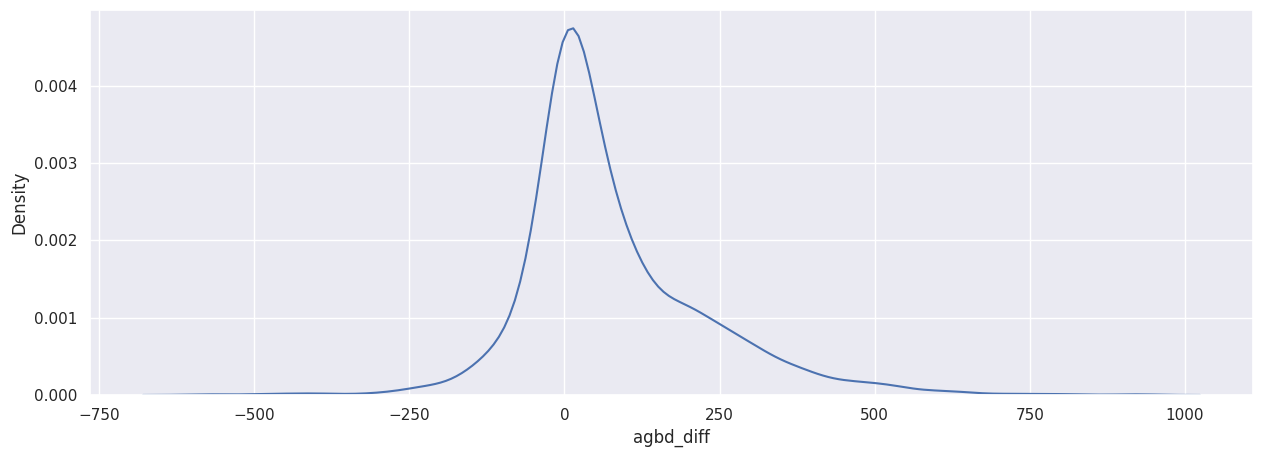

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(get_matches(burn_agbd_matches, 10), x="agbd_diff", ax=ax)

<Axes: xlabel='agbd_diff', ylabel='Density'>

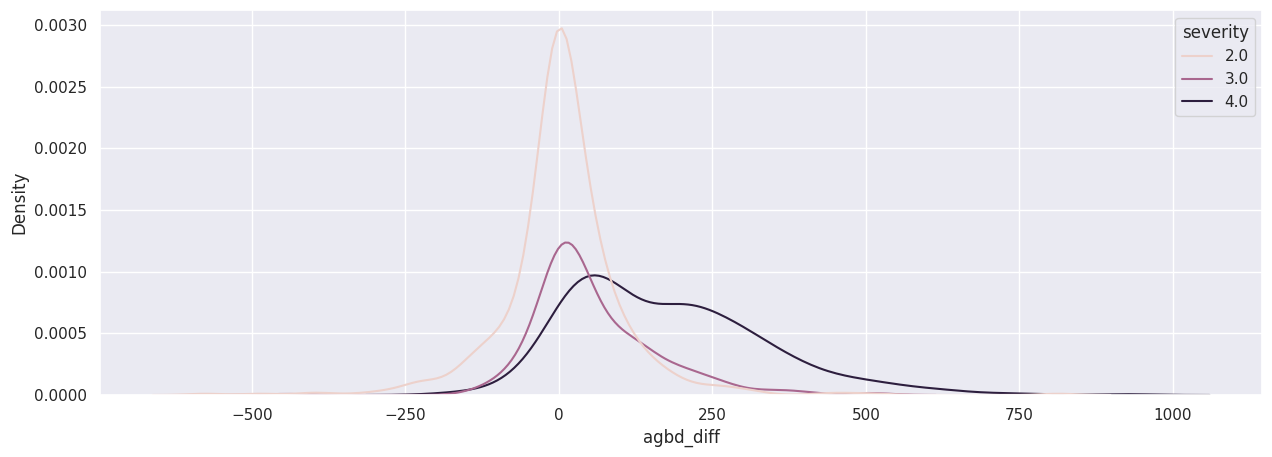

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(get_matches(burn_agbd_matches, 10), x="agbd_diff", hue="severity", ax=ax)

<Axes: xlabel='agbd_rel', ylabel='Density'>

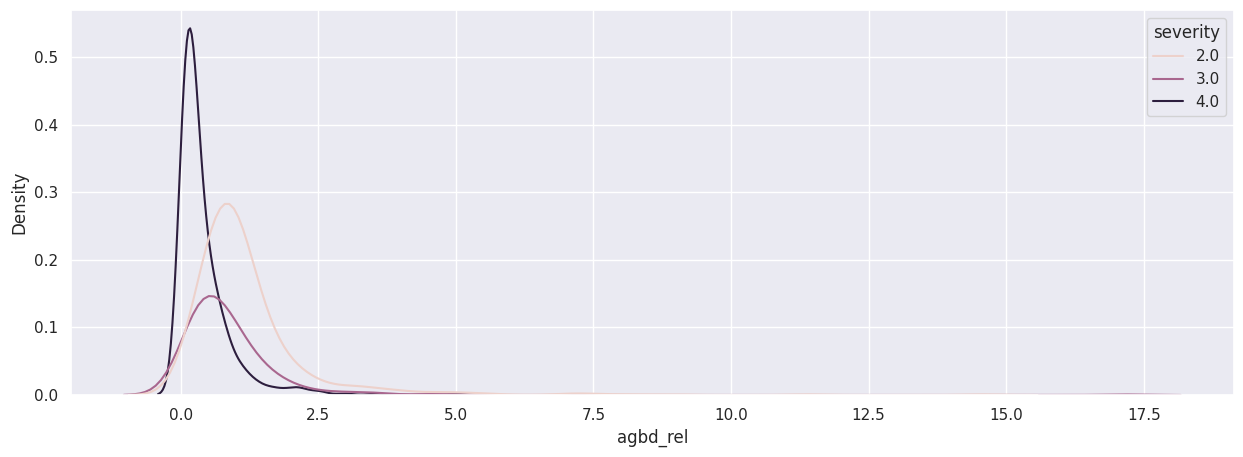

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(get_matches(burn_agbd_matches, 10), x="agbd_rel", hue="severity", ax=ax)

<Axes: xlabel='NDVI_mean', ylabel='Density'>

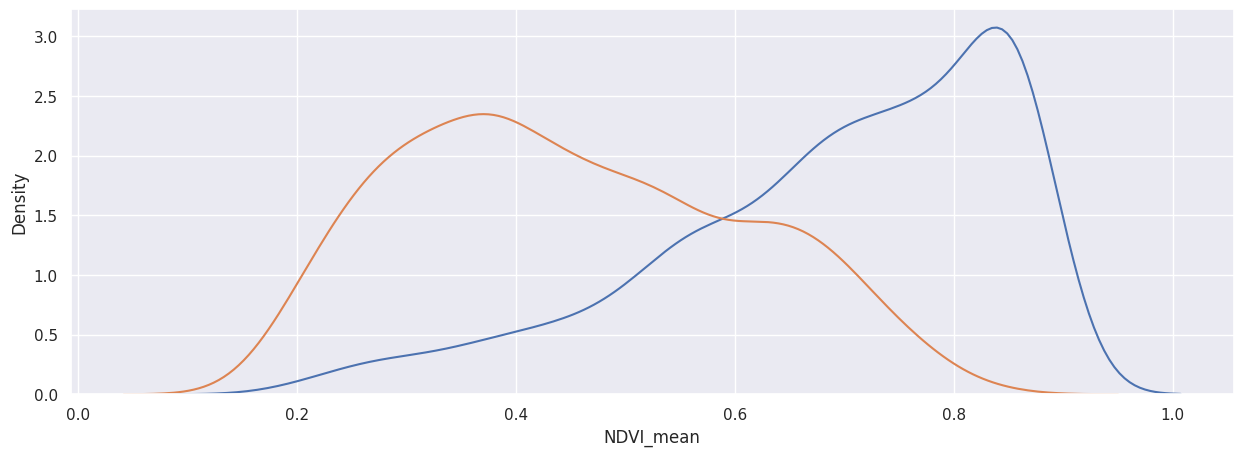

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(get_matches(burn_ndvi_matches, 10), x="NDVI_mean", ax=ax)
sns.kdeplot(get_matches(burn_ndvi_matches, 10), x="NDVI_mean_after", ax=ax)

<Axes: xlabel='NDVI_mean_diff', ylabel='Density'>

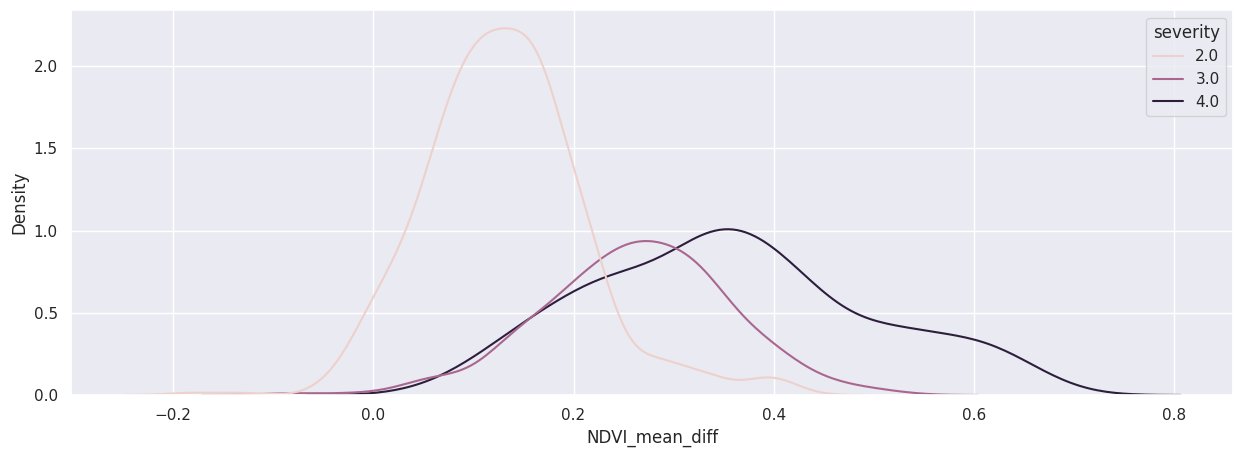

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(get_matches(burn_ndvi_matches, 10), x="NDVI_mean_diff", hue="severity", ax=ax)

<Axes: xlabel='NDVI_mean_rel', ylabel='Density'>

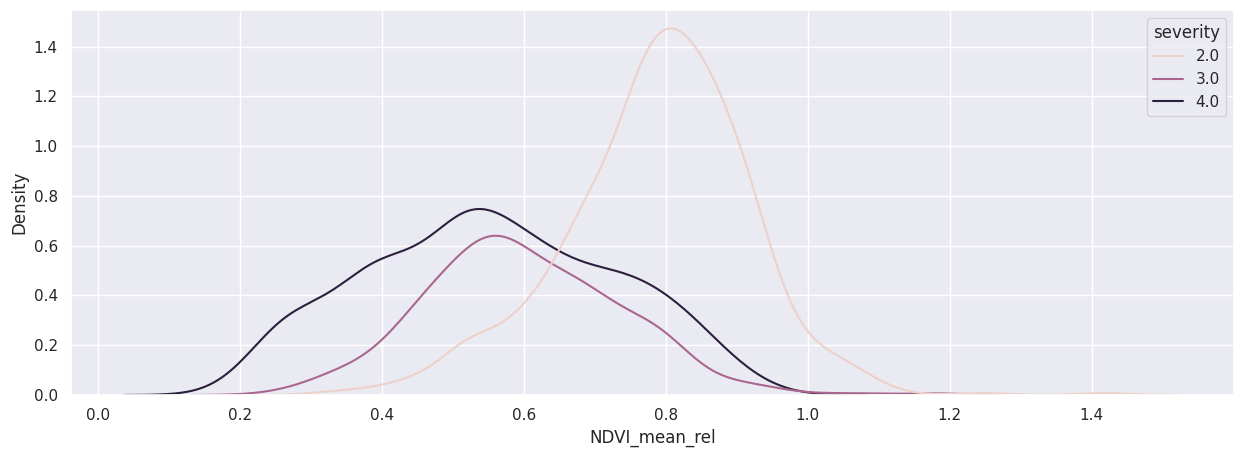

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(get_matches(burn_ndvi_matches, 10), x="NDVI_mean_rel", hue="severity", ax=ax)

In [47]:
# print stats
dist = 5
print(get_matches(burn_agbd_matches, dist).groupby("severity").mean(numeric_only=True)[["agbd_diff", "agbd_rel"]])
print(get_matches(burn_agbd_matches, dist).groupby("severity").median(numeric_only=True)[["agbd_diff", "agbd_rel"]])
print(get_matches(burn_agbd_matches, dist).groupby("severity").std(numeric_only=True)[["agbd_diff", "agbd_rel"]])
print(get_matches(burn_agbd_matches, dist).groupby("severity").count()[["agbd_diff", "agbd_rel"]])

           agbd_diff  agbd_rel
severity                      
2.0         0.964361  1.193736
3.0        57.421142  0.808603
4.0       165.451388  0.356314
           agbd_diff  agbd_rel
severity                      
2.0         1.859770  0.963815
3.0        32.751486  0.624193
4.0       137.447323  0.184986
           agbd_diff  agbd_rel
severity                      
2.0        90.624151  0.963030
3.0        93.273244  0.767855
4.0       144.129043  0.600649
          agbd_diff  agbd_rel
severity                     
2.0             179       179
3.0             107       107
4.0             113       113


In [43]:
# print stats
dist = 5
print(get_matches(burn_ndvi_matches, dist).groupby("severity").mean(numeric_only=True)[["NDVI_mean_diff", "NDVI_mean_rel"]])
print(get_matches(burn_ndvi_matches, dist).groupby("severity").median(numeric_only=True)[["NDVI_mean_diff", "NDVI_mean_rel"]])
print(get_matches(burn_ndvi_matches, dist).groupby("severity").std(numeric_only=True)[["NDVI_mean_diff", "NDVI_mean_rel"]])
print(get_matches(burn_ndvi_matches, dist).groupby("severity").count()[["NDVI_mean_diff", "NDVI_mean_rel"]])

          NDVI_mean_diff  NDVI_mean_rel
severity                               
2.0             0.141249       0.778840
3.0             0.263923       0.602450
4.0             0.391117       0.508956
          NDVI_mean_diff  NDVI_mean_rel
severity                               
2.0             0.141047       0.786112
3.0             0.259385       0.603104
4.0             0.375077       0.510358
          NDVI_mean_diff  NDVI_mean_rel
severity                               
2.0             0.076854       0.126718
3.0             0.084182       0.130105
4.0             0.144101       0.167484
          NDVI_mean_diff  NDVI_mean_rel
severity                               
2.0                  179            179
3.0                  107            107
4.0                  113            113


In [8]:
burn_agbd_matches = gedi_matching.match_across_fire_perimeters(sierra_firep.perimeters, gedi_burned, 'agbd')

Skipped fire GRADE. No matching GEDI shots found.
Skipped fire FORK. No matching GEDI shots found.
Skipped fire BLUEJAY. No matching GEDI shots found.
Skipped fire WOLF. No matching GEDI shots found.
Skipped fire OWENS. No matching GEDI shots found.
Skipped fire PEAK. No matching GEDI shots found.
Skipped fire RIVER. No matching GEDI shots found.


In [9]:
burn_agbd_matches

,shot_number,longitude,latitude,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,pft_class,...,shape_area_acres,closest_distance,match_datetime,agbd_after,agbd_diff,agbd_rel,start_offset,end_offset,cont_date,date_since
1526843,19580800300237130,-121.328457,39.383851,29.506557,-9999.000000,119.165398,11.106608,full,0.992217,1,...,1309.089917,219.445059,2022-04-17 22:00:38.416456+00:00,70.484428,-40.977871,2.388772,0,None,2020-10-13 00:00:00+00:00,17
1526844,19580800300237131,-121.327937,39.383529,75.385826,10.238125,200.655579,11.100525,full,0.985709,1,...,1309.089917,224.575134,2022-04-17 22:00:38.432988+00:00,27.511118,47.874708,0.364938,0,None,2020-10-13 00:00:00+00:00,17
1526846,19580800300237151,-121.317545,39.377115,81.240318,12.464673,210.138275,11.100574,full,0.987580,1,...,1309.089917,155.187375,2022-03-06 08:14:27.437308+00:00,31.754629,49.485689,0.390873,0,None,2020-10-13 00:00:00+00:00,16
1526847,19580800300237156,-121.314947,39.375509,97.278435,19.186817,235.490204,11.100173,full,0.968341,1,...,1309.089917,37.875583,2022-03-06 08:14:27.470371+00:00,69.563919,27.714516,0.715101,0,None,2020-10-13 00:00:00+00:00,16
1526852,19581100300228085,-121.332681,39.379712,75.904198,10.430404,201.497726,11.100094,full,0.974572,1,...,1309.089917,12.873282,2021-05-10 13:25:36.510392+00:00,91.804604,-15.900406,1.209480,0,None,2020-10-13 00:00:00+00:00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21702568,81650500200080254,-119.730004,38.771575,4.001528,-9999.000000,23.793789,2.995568,full,0.961544,6,...,1135.744413,65.810301,2022-03-10 13:09:34.651145+00:00,1.630395,2.371133,0.407443,0,None,2021-07-11 00:00:00+00:00,7
14884969,81650500200080250,-119.732036,38.770279,40.791206,12.344971,85.748657,2.986730,full,0.965436,6,...,1135.744413,1160.239831,2022-02-11 17:00:53.898642+00:00,16.075548,24.715658,0.394093,0,None,2021-07-11 00:00:00+00:00,6
14884970,81650500200080252,-119.731012,38.770928,6.163807,-9999.000000,28.709080,2.991151,full,0.967303,6,...,1135.744413,1259.054849,2022-02-11 17:00:53.898642+00:00,16.075548,-9.911741,2.608055,0,None,2021-07-11 00:00:00+00:00,6
14979393,33480100300285330,-119.742336,38.774865,22.512651,-9999.000000,104.639847,11.107887,coverage,0.982125,1,...,1135.744413,94.905960,2022-02-11 17:00:53.890378+00:00,14.050186,8.462465,0.624102,0,None,2021-07-11 00:00:00+00:00,6
